## Figures

* Synthetic greedy with a range of settings
* Synthetic greedy resource ratio
* Synthetic auction with a range of settings
* Synthetic DIA heuristic grid search
* Synthetic online batch sizes

## Model sizes
* 10 Tasks, 2 Servers (Elastic, Non elastic and Greedy)
* 15 Tasks, 3 Servers (Elastic, Non elastic and Greedy)
* 25 Tasks, 5 Servers (Non elastic and Greedy)
* 50 Tasks, 10 Servers (Greedy)
* 75 Tasks, 15 Servers (Greedy)

### P-test and paired t-test

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import os
import sys
import re
sys.path.append(os.path.join(os.getcwd(), ".."))

from src.extra.io import save_plot

matplotlib.rcParams['font.family'] = "monospace"
%matplotlib inline

In [2]:
def collect_results(folder, size, col, algos):
    results = []
    for filename in os.listdir(folder):
        if f't{size}_s' in filename:
            with open(f'{folder}/{filename}') as file:
                results += json.load(file)
    
    return [[model_results[algo][col] for model_results in results if algo in model_results] for algo in algos]

In [3]:
def get_model_size(filename):
    model_size = re.search(r't\d+_s\d+', filename).group(0)
    model_size = model_size.replace('t', '').replace('_s', ' Tasks, ') + ' Servers'
    return model_size

In [4]:
def performance_difference(filename, algo_1, algo_2, metric='social welfare'):
    with open(filename) as file:
        results_data = json.load(file)
    
    if not all(algo_1 in result and algo_2 in result for result in results_data):
        return f'{" and ".join([algo for algo in [algo_1, algo_2] if not all(algo in result for result in results_data)])} is missing'
        
    algo_1_results = np.array([result[algo_1][metric] for result in results_data])
    algo_2_results = np.array([result[algo_2][metric] for result in results_data])
    
    return f'{algo_1_results.mean():.3f}, {algo_2_results.mean():.3f}' \
        f'{algo_1_results.mean() / algo_2_results.mean():.3f}%, {(algo_1_results / algo_2_results).mean():.3f}%'

In [2]:
greedy_algo = 'Greedy Utility * deadline / Sum, Sum, Percent Sum'
greedy_algos_names = ['Server\nRelaxed\nElastic\nOptimal', 'Elastic\nOptimal', 
                      'Elastic\nGreedy\nAlgorithm', 'Non-elastic\nOptimal']

## Synthetic greedy with a range of settings

In [3]:
greedy_algos = ['Server Relaxed Flexible Optimal', 'Elastic Optimal', greedy_algo, 'Non-elastic Optimal']
greedy_folder = '../data/greedy'

sizes = sorted(set(int(re.search(r't\d+', filename).group(0).replace('t', ''))
                  for filename in os.listdir(greedy_folder)))
sizes

NameError: name 'os' is not defined

In [ ]:
greedy_size = {}
for filename in sorted(os.listdir(greedy_folder), key=lambda f: int(re.search(r't\d+', f).group(0).replace('t', ''))):
    with open(f'{greedy_folder}/{filename}') as file:
        greedy_size[filename] = len(json.load(file))
        
greedy_size

Save file location: figs/eps/greedy_social_welfare.eps
Save file location: figs/png/greedy_social_welfare.png
Save file location: figs/pdf/greedy_social_welfare.pdf


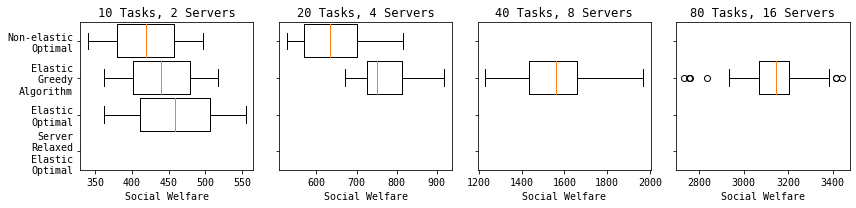

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for ax, size in zip(axs, sizes):
    model_size_result = collect_results(greedy_folder, size, 'social welfare', greedy_algos)
    ax.boxplot(model_size_result, vert=False, widths=0.9)
    
    ax.set_xlabel('Social Welfare')
    ax.set_yticklabels([''] * len(greedy_algos))
    ax.set_title(get_model_size(next(filename for filename in os.listdir(greedy_folder) 
                                     if f't{size}_s' in filename)))

axs[0].set_yticklabels(greedy_algos_names)
fig.tight_layout()
save_plot('greedy_social_welfare')

In [ ]:
print('\tPerformance difference in social welfare')
for algo_1, algo_2 in (('non-elastic optimal', 'elastic optimal'), (greedy_algo, 'elastic optimal'), 
                       ('non-elastic optimal', greedy_algo), (greedy_algo, 'server relaxed elastic optimal')):
    print(f'{algo_1.title()} vs {algo_2.title()}')
    for size in sizes:
        print(f'\t{size}: {performance_difference(size, algo_1, algo_2)}')

In [12]:
for size in sizes:
    greedy_results = collect_results(greedy_folder, size, 'social welfare percent', [greedy_algo])
    print(f'{size}: {np.mean(greedy_results)}')

10: 0.921
20: 0.7594166666666666
40: 0.7810799999999999
80: 0.7899200000000001
160: 0.8038


### Greedy  resource usage

In [ ]:
fig, axs = plt.subplots(len(greedy_filenames), 4, figsize=(14, 3*len(greedy_filenames)))
for pos, filename in enumerate(greedy_filenames):
    print(filename)
    with open(f'{greedy_folder}/{filename}') as file:
        data = json.load(file)

    algo_resource_usage = {algo: {'storage': [], 'compute': [], 'bandwidth': []} for algo in greedy_algos}
    for result in data:
        for algo in greedy_algos:
            if algo in result:
                algo_resource_usage[algo]['storage'] += list(result[algo]['server storage usage'].values())
                algo_resource_usage[algo]['compute'] += list(result[algo]['server compute usage'].values())
                algo_resource_usage[algo]['bandwidth'] += list(result[algo]['server bandwidth usage'].values())

    for ax, (algo, resource_usage), name in zip(axs[pos], algo_resource_usage.items(), greedy_algos_names):
        ax.set_title(name)
        for resource, usage in resource_usage.items():
            ax.hist(usage, bins=10, label=resource)
        ax.legend()
    axs[pos, 0].set_ylabel(get_model_size(filename))

plt.tight_layout()

## Synthetic auction with a range of settings

In [37]:
auction_folder = '../data/auctions/'
auction_filenames = sorted(os.listdir(auction_folder))

auction_filenames

['auctions_synthetic_r_t10_s2_dt06-11_11-37-18.json',
 'auctions_synthetic_r_t15_s3_dt06-11_11-37-18.json',
 'auctions_synthetic_r_t30_s6_dt06-11_11-38-03.json',
 'auctions_synthetic_r_t40_s8_dt06-11_11-37-05.json']

In [50]:
critical_value_name = 'Critical Value Auction' + greedy_algo.replace('Greedy', '')
auction_algos = ['Fixed VCG', 'Optimal DIA', critical_value_name, 'Flexible VCG']
auction_algo_names = ['Non-Elastic\nVCG Auction', 'Elastic\nDecentralised\nIterative Auction', 
                      'Elastic Critical\nValue Auction', 'Elastic VCG\nAuction']

Save file location: figs/eps/auctions_social_welfare.eps
Save file location: figs/png/auctions_social_welfare.png
Save file location: figs/pdf/auctions_social_welfare.pdf


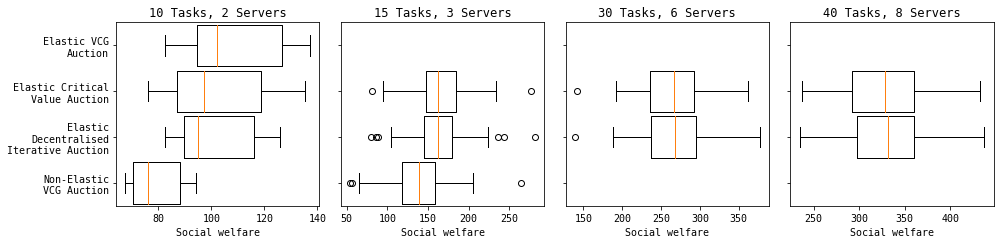

In [51]:
fig, axs = plt.subplots(1, len(auction_filenames), figsize=(14, 3.5))
for ax, filename in zip(axs, auction_filenames):
    results = collect_results(f'{auction_folder}/{filename}', 'social welfare', auction_algos)
    ax.boxplot(results, vert=False, widths=0.9)
    ax.set_xlabel('Social welfare')
    ax.set_yticklabels(['', '', '', ''])
    ax.set_title(get_model_size(filename))
    
axs[0].set_yticklabels(auction_algo_names)
fig.tight_layout()
save_plot('auctions_social_welfare')

Save file location: figs/eps/auctions_revenue.eps
Save file location: figs/png/auctions_revenue.png
Save file location: figs/pdf/auctions_revenue.pdf


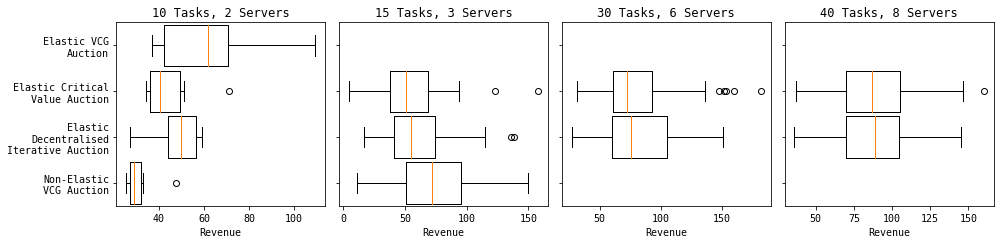

In [53]:
fig, axs = plt.subplots(1, len(auction_filenames), figsize=(14, 3.5))
for ax, filename in zip(axs, auction_filenames):
    results = collect_results(f'{auction_folder}/{filename}', 'total revenue', auction_algos)
    ax.boxplot(results, vert=False, widths=0.9)
    ax.set_xlabel('Revenue')
    ax.set_yticklabels(['', '', '', ''])
    ax.set_title(get_model_size(filename))
    
axs[0].set_yticklabels(auction_algo_names)
fig.tight_layout()
save_plot('auctions_revenue')

In [ ]:
['Fixed VCG', 'Optimal DIA', critical_value_name, 'Flexible VCG']

In [ ]:
print('\tPerformance difference in social welfare')
for algo_1, algo_2 in (('Fixed VCG', 'Flexible VCG'), (critical_value_name, 'Flexible VCG'), 
                       ('Fixed VCG', critical_value_name), (greedy_name, 'Optimal DIA')):
    print(f'{algo_1.title()} vs {algo_2.title()}')
    for filename in auction_filenames:
        print(f'\t{get_model_name(filename)}: {performance_difference(filename, algo_1, algo_2)}')

In [ ]:
print('\tPerformance difference in revenue')
for algo_1, algo_2 in (('Fixed VCG', 'Flexible VCG'), (critical_value_name, 'Flexible VCG'), 
                       ('Fixed VCG', critical_value_name), (greedy_name, 'Optimal DIA')):
    print(f'{algo_1.title()} vs {algo_2.title()}')
    for filename in auction_filenames:
        print(f'\t{get_model_name(filename)}: {performance_difference(filename, algo_1, algo_2, "revenue")}')